In [5]:
import numpy as np
import cv2
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import normalize, to_tensor
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

### Creating the dataset

In [2]:
DATA_FILE_PATH = "./data"


class Pandora18KDataset(Dataset):
    def __init__(self, images_root, style, load_shape=(224, 224)):
        self.load_shape = load_shape
        self.images = []
        self.labels = []

        art_styles = sorted(glob.glob(images_root + "/*/"))

        for image in glob.glob(art_styles[style] + "/**/*.jpg", recursive=True):
            self.images.append(image)
            self.labels.append(style)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])

        image = cv2.resize(image, self.load_shape)

        label = self.labels[idx]

        return image, label

    def __len__(self):
        return len(self.images)

In [3]:
def create_datasets(shape):
    train_dataset = []
    test_dataset = []

    for idx in range(18):
        dataset = Pandora18KDataset(DATA_FILE_PATH, idx, shape)
        train, test = train_test_split(dataset, test_size=0.2, random_state=73)

        train_dataset.extend(train)
        test_dataset.extend(test)

    random.seed(73)
    random.shuffle(train_dataset)

    return train_dataset, test_dataset

In [4]:
def dataset_weights(images_root):
    weights = [0 for _ in range(18)]

    art_styles = sorted(glob.glob(images_root + "/*/"))

    for idx in range(len(art_styles)):
        for _ in glob.glob(art_styles[idx] + "/**/*.jpg", recursive=True):
            weights[idx] += 1

    total = sum(weights)

    weights = [total / (weight * 10) for weight in weights]

    return torch.tensor(weights).cuda()


weights = dataset_weights(DATA_FILE_PATH)

### Train and test accuracy functions

In [5]:
def test_accuracy(model: nn.Module, test_dataloader: DataLoader):
    # Evaluation mode
    model.eval()

    total = 0
    correct = 0

    with torch.no_grad():
        for test_images, test_labels in test_dataloader:
            test_images = test_images.cuda()
            test_labels = test_labels.cuda()

            total += len(test_labels)

            out_class = torch.argmax(model(test_images), dim=1)
            correct += torch.sum(out_class == test_labels)

    return correct.cpu() / total * 100


def train_fn(epochs: int, train_dataloader: DataLoader, test_dataloader: DataLoader, model: nn.Module,
             loss_fn: nn.Module, optimizer: optim.Optimizer):
    train_losses = []
    test_accuracies = []

    with open("models/" + model.__class__.__name__ + ".txt", "r") as max_accuracy_file:
        max_accuracy = float(max_accuracy_file.read())

    for epoch in range(epochs):
        train_loss = 0.0

        # Train mode
        model.train()

        for idx, (image, label) in enumerate(train_dataloader):
            pred = model(image.cuda())

            loss = loss_fn(pred, label.cuda())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()

            if idx % 50 == 0:
                print("Epoch:{}.{} Loss {:.4f}".format(epoch, idx, loss.item()))

        # Calculate average losses
        train_loss /= len(train_dataloader)
        print("Epoch:{}. Average Loss: {:.4f}, ".format(epoch, train_loss), end="")

        accuracy = test_accuracy(model, test_dataloader)
        print("Test accuracy: {:.4f}%".format(accuracy))

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            with open("models/" + model.__class__.__name__ + ".txt", "w") as max_accuracy_file:
                max_accuracy_file.write("{}\n".format(max_accuracy))

            torch.save(model.state_dict(), "models/" + model.__class__.__name__)

        train_losses.append(train_loss)
        test_accuracies.append(accuracy)

    # Plot the train loss and test accuracy
    figure, axis = plt.subplots(1, 2)

    figure.set_figheight(4)
    figure.set_figwidth(16)

    axis[0].plot(train_losses)
    axis[0].set_xlabel('Epoch')
    axis[0].set_ylabel('Train loss')

    axis[1].plot(test_accuracies)
    axis[1].set_xlabel('Epoch')
    axis[1].set_ylabel('Test Accuracy')

    plt.show()

### Metrics

In [6]:
labels = ["Byzantine", "Early Ren.", "High Ren.", "Rococo", "Romanticism", "North Ren", "Baroque", "Realism",
          "Impress.", "Post Impr.", "Symbolism", "Surrealism", "Fauvism", "Expressionism", "Cubism", "Abstract",
          "Naive art", "Pop art"]

In [7]:
def correct_predicted_labels(model: nn.Module, test_dataloader: DataLoader):
    # Evaluation mode
    model.eval()

    correct = np.array([])
    predicted = np.array([])

    with torch.no_grad():
        for test_images, test_labels in test_dataloader:
            if isinstance(test_images, tuple):
                test_images = (test_images[0].cuda(), test_images[1].cuda())
            else:
                test_images = test_images.cuda()

            out_class = torch.argmax(model(test_images), dim=1)

            correct = np.append(correct, test_labels.numpy())
            predicted = np.append(predicted, out_class.cpu().numpy())

    return correct, predicted


def metrics(model: nn.Module, test_dataloader: DataLoader):
    try:
        model.load_state_dict(torch.load("models/" + model.__class__.__name__))
    except FileNotFoundError:
        pass

    correct, predicted = correct_predicted_labels(model, test_dataloader)

    print("Test accuracy: {:.4f}%".format(accuracy_score(correct, predicted) * 100))

    _, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_predictions(correct, predicted, display_labels=labels, cmap="Blues",
                                            xticks_rotation='vertical', ax=ax, normalize='true', values_format='.2f')

# One-Stage Neural Network

In [8]:
def collate_fn(examples):
    images = []
    labels = []

    for example in examples:
        image, label = example

        image = to_tensor(image)
        image = normalize(image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        image = image.unsqueeze(0)
        images.append(image)

        label = torch.tensor(label).unsqueeze(0)
        labels.append(label)

    images_batch = torch.cat(images)
    labels_batch = torch.cat(labels)

    return images_batch, labels_batch

## Fine-tuned ResNet

In [9]:
class FineTunedResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, 18)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.resnet50(x)
        x = self.softmax(x)

        return x

In [10]:
train_dataset, test_dataset = create_datasets((224, 224))

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=40, num_workers=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn)

In [13]:
epochs = 20
lr = 5e-5

model = FineTunedResNet().cuda()

loss_fn = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.AdamW(model.parameters(), lr=lr)
optimizer.zero_grad()

Epoch:0.0 Loss 2.8923
Epoch:0.50 Loss 2.8823
Epoch:0.100 Loss 2.8570
Epoch:0.150 Loss 2.7911
Epoch:0.200 Loss 2.6341
Epoch:0.250 Loss 2.6860
Epoch:0.300 Loss 2.5933
Epoch:0.350 Loss 2.4904
Epoch:0. Average Loss: 2.7160, Test accuracy: 41.7865%
Epoch:1.0 Loss 2.4219
Epoch:1.50 Loss 2.3959
Epoch:1.100 Loss 2.5360
Epoch:1.150 Loss 2.5827
Epoch:1.200 Loss 2.4110
Epoch:1.250 Loss 2.3839
Epoch:1.300 Loss 2.5008
Epoch:1.350 Loss 2.4453
Epoch:1. Average Loss: 2.4629, Test accuracy: 57.6881%
Epoch:2.0 Loss 2.4526
Epoch:2.50 Loss 2.2322
Epoch:2.100 Loss 2.3535
Epoch:2.150 Loss 2.4322
Epoch:2.200 Loss 2.4730
Epoch:2.250 Loss 2.3209
Epoch:2.300 Loss 2.2832
Epoch:2.350 Loss 2.2666
Epoch:2. Average Loss: 2.3189, Test accuracy: 62.6659%
Epoch:3.0 Loss 2.2782
Epoch:3.50 Loss 2.2333
Epoch:3.100 Loss 2.1822
Epoch:3.150 Loss 2.2454
Epoch:3.200 Loss 2.0997
Epoch:3.250 Loss 2.3042
Epoch:3.300 Loss 2.2724
Epoch:3.350 Loss 2.2902
Epoch:3. Average Loss: 2.2347, Test accuracy: 63.2467%
Epoch:4.0 Loss 2.3020
Ep

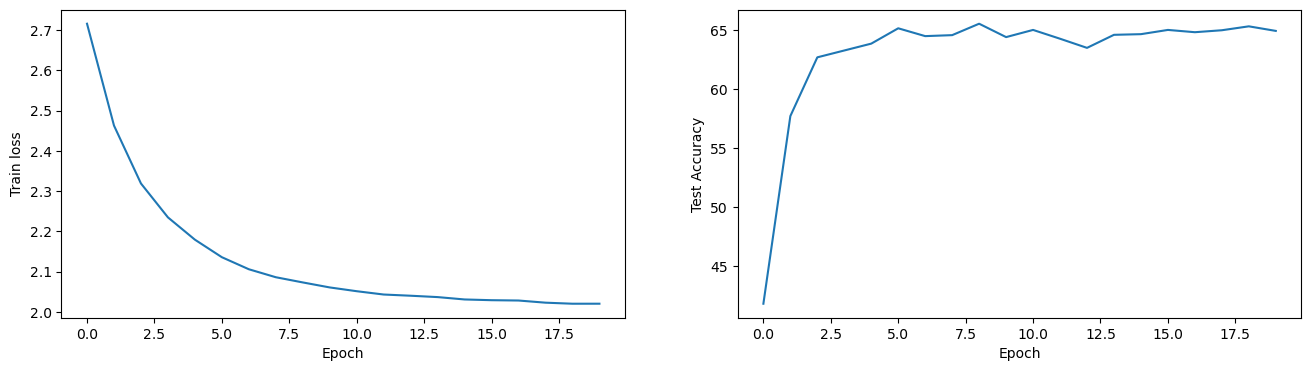

In [14]:
train_fn(epochs, train_dataloader, test_dataloader, model, loss_fn, optimizer)

Test accuracy: 65.5144%


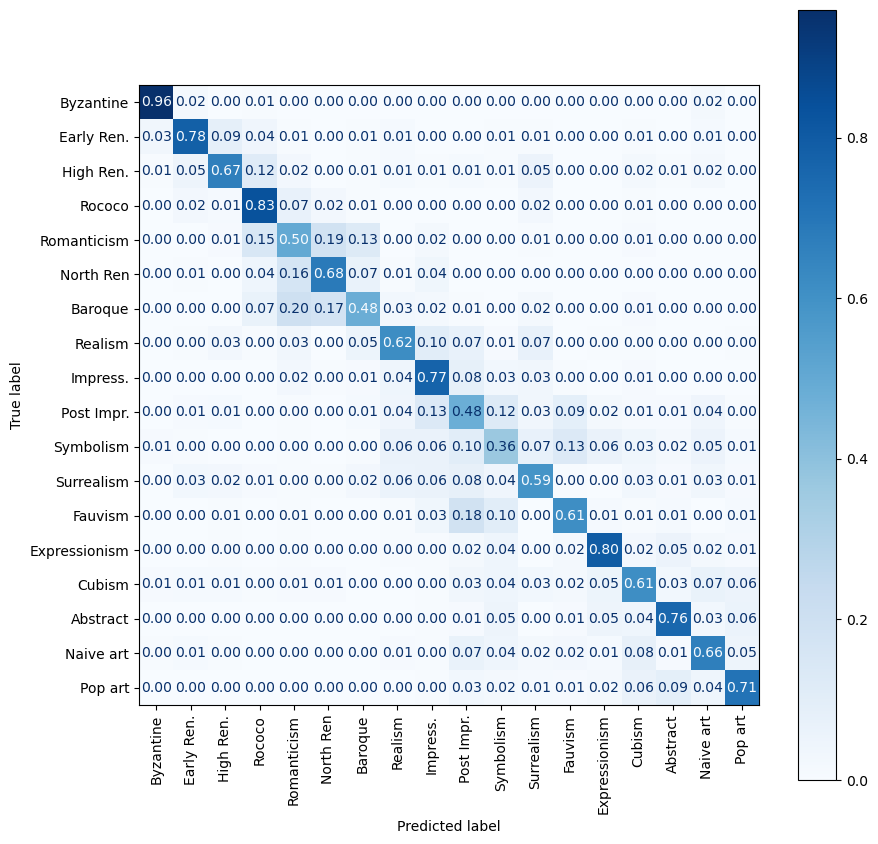

In [15]:
metrics(model, test_dataloader)

## Fine-tuned InceptionNet

In [11]:
class FineTunedInceptionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.inceptionv3 = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
        self.inceptionv3.fc = torch.nn.Linear(self.inceptionv3.fc.in_features, 18)

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.inceptionv3(x)

        if self.training:
            x = x.logits

        x = self.softmax(x)

        return x

In [17]:
train_dataset, test_dataset = create_datasets((299, 299))

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn)

In [19]:
epochs = 20
lr = 5e-5

model = FineTunedInceptionNet().cuda()

loss_fn = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.AdamW(model.parameters(), lr=lr)
optimizer.zero_grad()

Epoch:0.0 Loss 2.8912
Epoch:0.50 Loss 2.8726
Epoch:0.100 Loss 2.7851
Epoch:0.150 Loss 2.7014
Epoch:0.200 Loss 2.6877
Epoch:0.250 Loss 2.5873
Epoch:0.300 Loss 2.5926
Epoch:0.350 Loss 2.6659
Epoch:0.400 Loss 2.5800
Epoch:0.450 Loss 2.5543
Epoch:0. Average Loss: 2.6696, Test accuracy: 42.5055%
Epoch:1.0 Loss 2.5913
Epoch:1.50 Loss 2.4455
Epoch:1.100 Loss 2.5120
Epoch:1.150 Loss 2.4420
Epoch:1.200 Loss 2.4100
Epoch:1.250 Loss 2.4903
Epoch:1.300 Loss 2.4735
Epoch:1.350 Loss 2.5367
Epoch:1.400 Loss 2.4444
Epoch:1.450 Loss 2.5078
Epoch:1. Average Loss: 2.4805, Test accuracy: 57.0243%
Epoch:2.0 Loss 2.4373
Epoch:2.50 Loss 2.4790
Epoch:2.100 Loss 2.2961
Epoch:2.150 Loss 2.3933
Epoch:2.200 Loss 2.2740
Epoch:2.250 Loss 2.3508
Epoch:2.300 Loss 2.3382
Epoch:2.350 Loss 2.3020
Epoch:2.400 Loss 2.3073
Epoch:2.450 Loss 2.3878
Epoch:2. Average Loss: 2.3657, Test accuracy: 59.8451%
Epoch:3.0 Loss 2.3476
Epoch:3.50 Loss 2.3535
Epoch:3.100 Loss 2.2594
Epoch:3.150 Loss 2.2853
Epoch:3.200 Loss 2.2554
Epoch:3

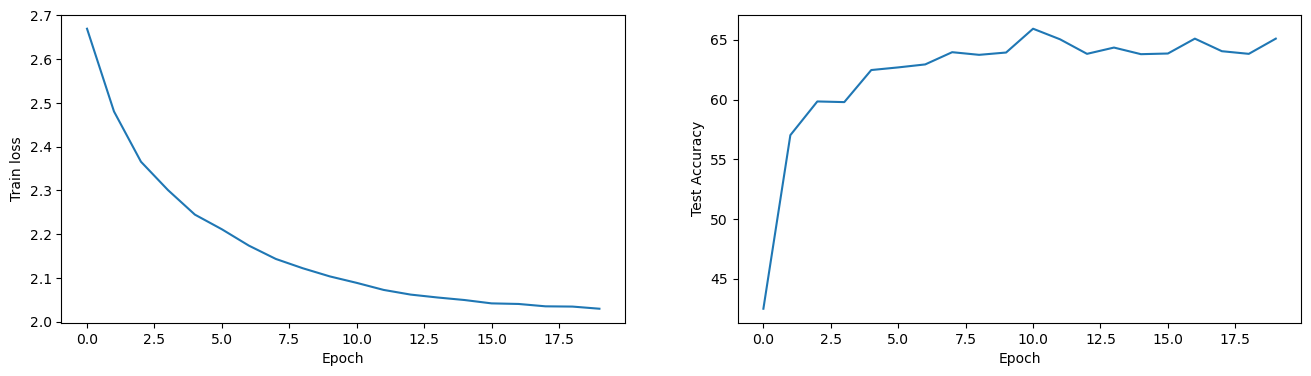

In [20]:
train_fn(epochs, train_dataloader, test_dataloader, model, loss_fn, optimizer)

Test accuracy: 65.9292%


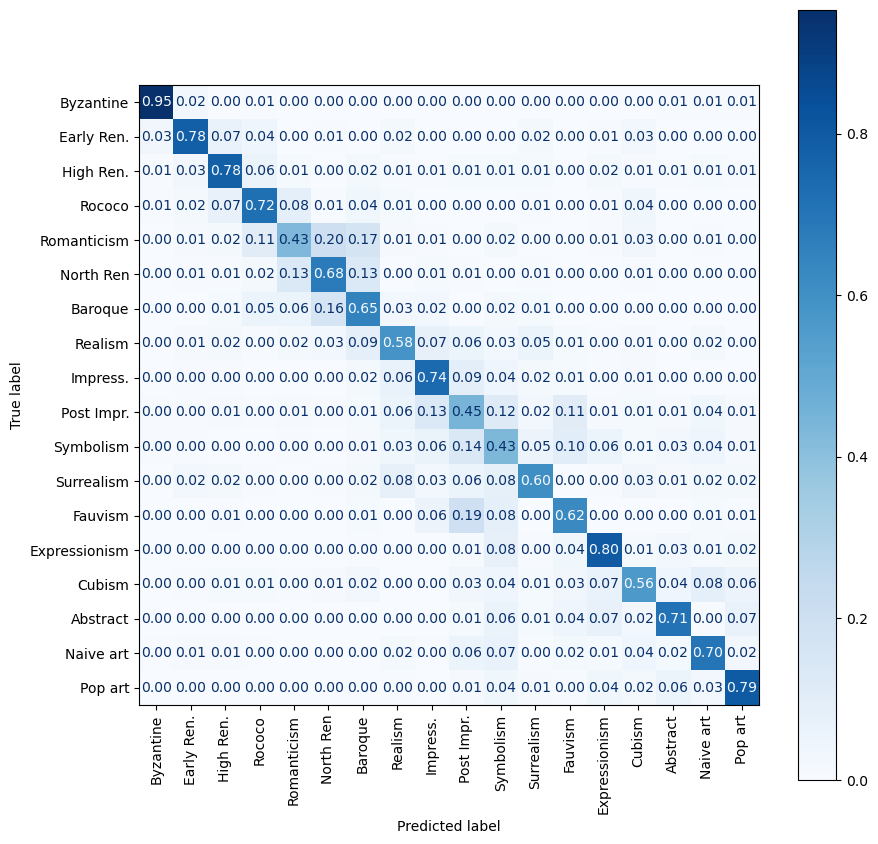

In [21]:
metrics(model, test_dataloader)

## Fine-tuned EfficientNet

In [10]:
class FineTunedEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.efficientnetv2 = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        self.efficientnetv2.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.efficientnetv2.classifier[1].in_features, 18),
        )

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.efficientnetv2(x)
        x = self.softmax(x)

        return x

In [10]:
train_dataset, test_dataset = create_datasets((224, 224))

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=22, num_workers=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn)

In [12]:
epochs = 20
lr = 5e-5

model = FineTunedEfficientNet().cuda()

loss_fn = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.AdamW(model.parameters(), lr=lr)
optimizer.zero_grad()

Epoch:0.0 Loss 2.8871
Epoch:0.50 Loss 2.8857
Epoch:0.100 Loss 2.8487
Epoch:0.150 Loss 2.8484
Epoch:0.200 Loss 2.6990
Epoch:0.250 Loss 2.6635
Epoch:0.300 Loss 2.6824
Epoch:0.350 Loss 2.7115
Epoch:0.400 Loss 2.5392
Epoch:0.450 Loss 2.4975
Epoch:0.500 Loss 2.5077
Epoch:0.550 Loss 2.4755
Epoch:0.600 Loss 2.6639
Epoch:0.650 Loss 2.5518
Epoch:0. Average Loss: 2.7083, Test accuracy: 46.3772%
Epoch:1.0 Loss 2.5131
Epoch:1.50 Loss 2.3825
Epoch:1.100 Loss 2.6498
Epoch:1.150 Loss 2.3184
Epoch:1.200 Loss 2.4806
Epoch:1.250 Loss 2.4938
Epoch:1.300 Loss 2.3397
Epoch:1.350 Loss 2.6332
Epoch:1.400 Loss 2.4455
Epoch:1.450 Loss 2.4624
Epoch:1.500 Loss 2.4174
Epoch:1.550 Loss 2.3402
Epoch:1.600 Loss 2.4301
Epoch:1.650 Loss 2.4472
Epoch:1. Average Loss: 2.4761, Test accuracy: 56.8308%
Epoch:2.0 Loss 2.3146
Epoch:2.50 Loss 2.2892
Epoch:2.100 Loss 2.3968
Epoch:2.150 Loss 2.3658
Epoch:2.200 Loss 2.4921
Epoch:2.250 Loss 2.3765
Epoch:2.300 Loss 2.4494
Epoch:2.350 Loss 2.4760
Epoch:2.400 Loss 2.3152
Epoch:2.450

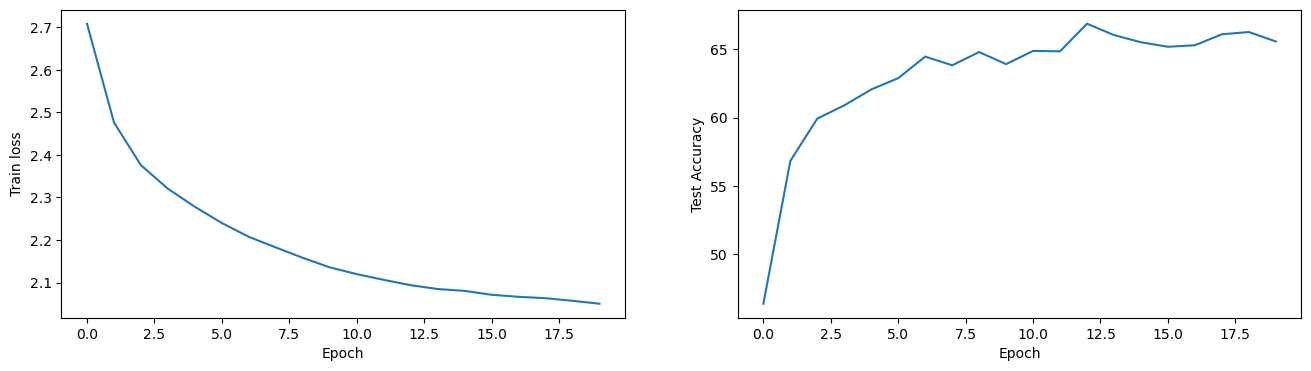

In [13]:
train_fn(epochs, train_dataloader, test_dataloader, model, loss_fn, optimizer)

Test accuracy: 66.8695%


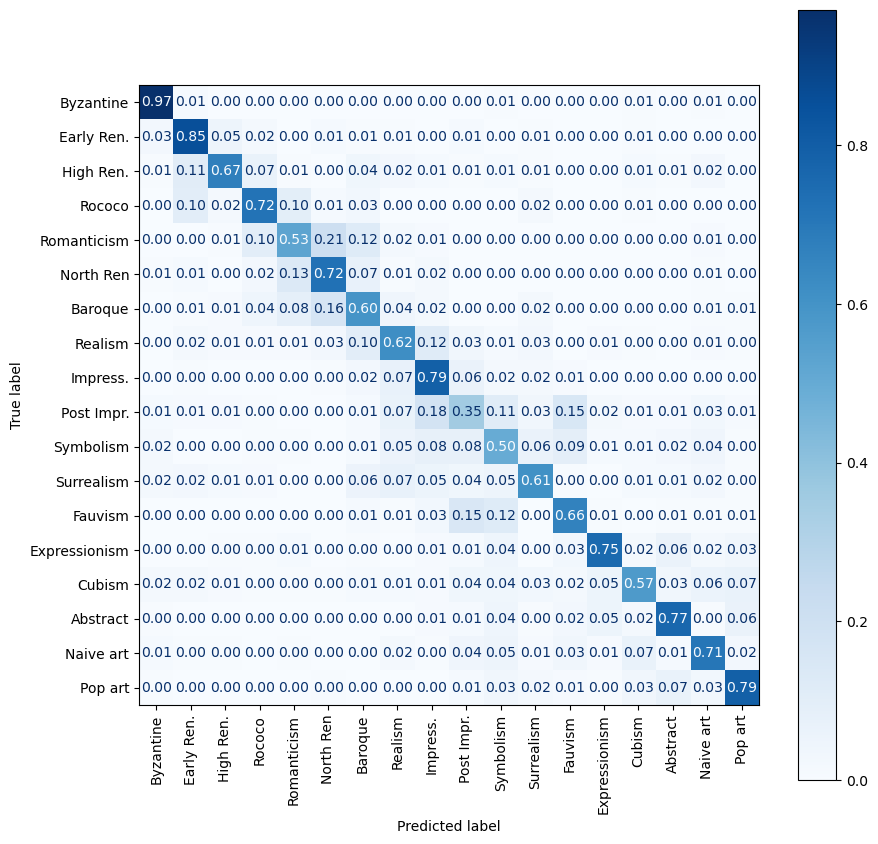

In [14]:
metrics(model, test_dataloader)

# Two-Stage Deep Neural Network

In [13]:
def twostage_collate_fn(examples):
    images = []
    labels = []

    for example in examples:
        image, label = example

        patches = []

        patches.append(image[:image.shape[0] // 2, :image.shape[1] // 2])
        patches.append(image[:image.shape[0] // 2, image.shape[1] // 2:])
        patches.append(image[image.shape[0] // 2:, :image.shape[1] // 2])
        patches.append(image[image.shape[0] // 2:, image.shape[1] // 2:])
        patches.append(image[image.shape[0] // 4:image.shape[0] * 3 // 4, image.shape[1] // 4:image.shape[1] * 3 // 4])
        patches.append(cv2.resize(image, (image.shape[0] // 2, image.shape[1] // 2)))

        for patch in patches:
            patch = to_tensor(patch)
            patch = normalize(patch, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            patch = patch.unsqueeze(0)
            images.append(patch)

        label = torch.tensor(label).unsqueeze(0)
        labels.append(label)

    images_batch = torch.cat(images)
    labels_batch = torch.cat(labels)

    return images_batch, labels_batch

### To try

* LeakyReLU
* ELU
* BatchNorm1D

In [16]:
class TwoStageNet(nn.Module):
    def __init__(self, dnn: nn.Module):
        super().__init__()

        self.dnn = dnn
        self.dnn.load_state_dict(torch.load("models/" + self.dnn.__class__.__name__))

        self.snn = []

        self.snn.append(nn.Linear(108, 3888))
        self.snn.append(nn.BatchNorm1d(num_features=3888))
        self.snn.append(nn.ReLU())

        self.snn.append(nn.Linear(3888, 648))
        self.snn.append(nn.BatchNorm1d(num_features=648))
        self.snn.append(nn.ReLU())

        self.snn.append(nn.Linear(648, 18))

        self.snn = nn.Sequential(*self.snn)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.dnn(x)
        x = self.softmax(x)

        x = torch.reshape(x, (x.shape[0] // 6, x.shape[1] * 6))

        x = self.snn(x)
        x = self.softmax(x)

        return x

## ResNet

In [13]:
train_dataset, test_dataset = create_datasets((448, 448))

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=40, num_workers=8, shuffle=True, collate_fn=twostage_collate_fn)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=twostage_collate_fn)

In [15]:
epochs = 20
lr = 1e-2

model = TwoStageNet(FineTunedResNet()).cuda()

for idx, param in enumerate(model.parameters()):
    if idx <= 160:
        param.requires_grad = False
    else:
        break

loss_fn = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
optimizer.zero_grad()

Epoch:0.0 Loss 2.8820
Epoch:0.50 Loss 2.2810
Epoch:0.100 Loss 2.2413
Epoch:0.150 Loss 2.2527
Epoch:0.200 Loss 2.2003
Epoch:0.250 Loss 2.3539
Epoch:0.300 Loss 2.4822
Epoch:0.350 Loss 2.3514
Epoch:0. Average Loss: 2.2982, Test accuracy: 54.2588%
Epoch:1.0 Loss 2.3120
Epoch:1.50 Loss 2.3474
Epoch:1.100 Loss 2.2148
Epoch:1.150 Loss 2.2339
Epoch:1.200 Loss 2.3435
Epoch:1.250 Loss 2.2175
Epoch:1.300 Loss 2.2613
Epoch:1.350 Loss 2.1640
Epoch:1. Average Loss: 2.2732, Test accuracy: 54.9226%
Epoch:2.0 Loss 2.4017
Epoch:2.50 Loss 2.2277
Epoch:2.100 Loss 2.1181
Epoch:2.150 Loss 2.2497
Epoch:2.200 Loss 2.1201
Epoch:2.250 Loss 2.3664
Epoch:2.300 Loss 2.2289
Epoch:2.350 Loss 2.1998
Epoch:2. Average Loss: 2.2358, Test accuracy: 55.5033%
Epoch:3.0 Loss 2.3008
Epoch:3.50 Loss 2.2810
Epoch:3.100 Loss 2.3131
Epoch:3.150 Loss 2.1815
Epoch:3.200 Loss 2.3239
Epoch:3.250 Loss 2.2584
Epoch:3.300 Loss 2.2001
Epoch:3.350 Loss 2.1971
Epoch:3. Average Loss: 2.2190, Test accuracy: 56.9690%
Epoch:4.0 Loss 2.2320
Ep

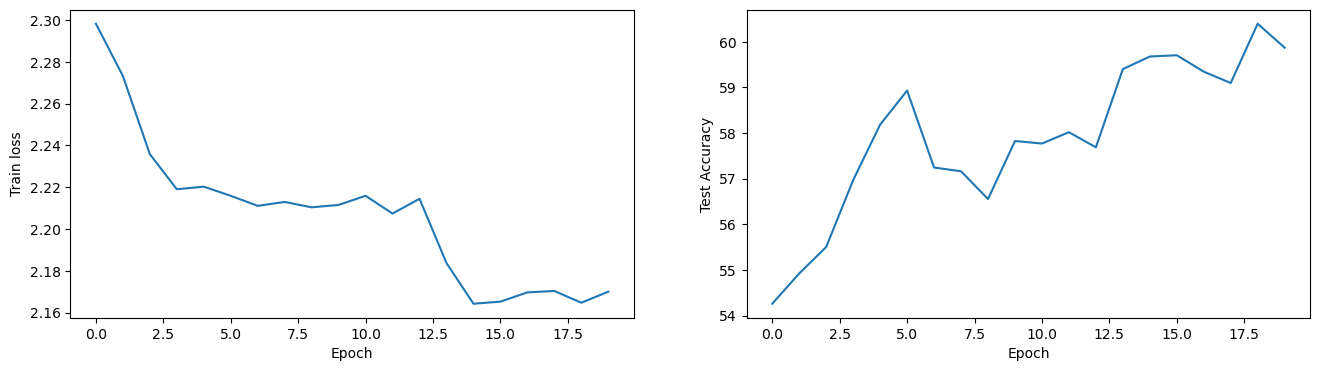

In [16]:
train_fn(epochs, train_dataloader, test_dataloader, model, loss_fn, optimizer)

Test accuracy: 60.3982%


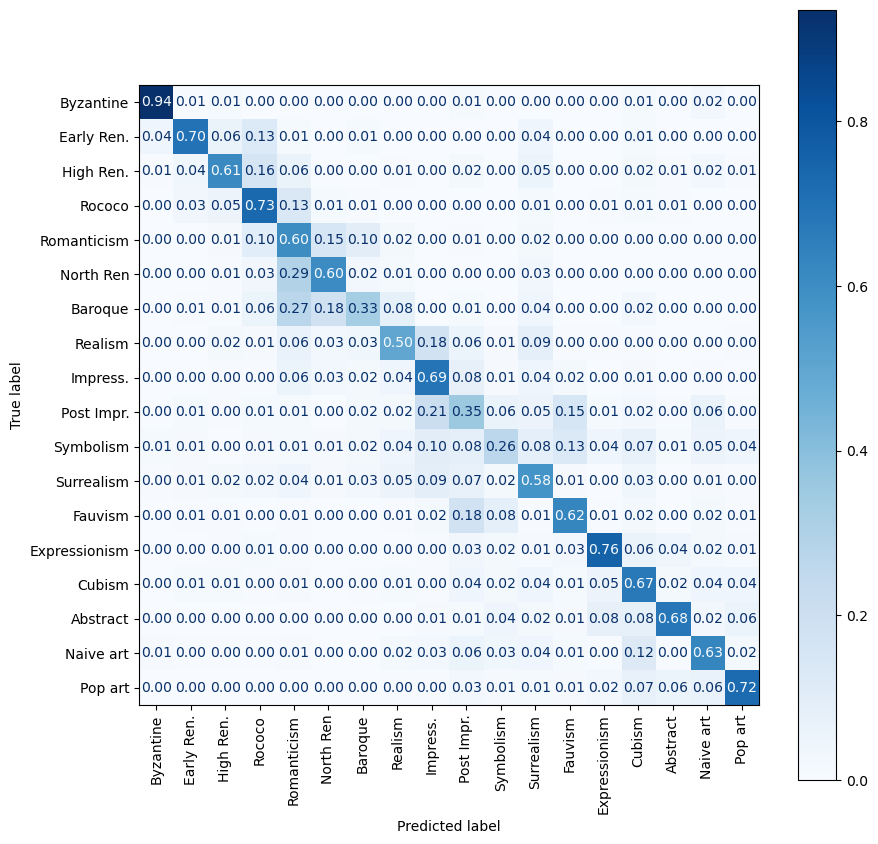

In [17]:
metrics(model, test_dataloader)

## InceptionNet

In [ ]:
train_dataset, test_dataset = create_datasets((598, 598))

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True, collate_fn=twostage_collate_fn)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=twostage_collate_fn)

In [ ]:
epochs = 20
lr = 1e-2

model = TwoStageNet(FineTunedInceptionNet()).cuda()

for idx, param in enumerate(model.parameters()):
    if idx <= 291:
        param.requires_grad = False
    else:
        break

loss_fn = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
optimizer.zero_grad()

In [ ]:
train_fn(epochs, train_dataloader, test_dataloader, model, loss_fn, optimizer)

In [ ]:
metrics(model, test_dataloader)

## EfficientNet

In [11]:
train_dataset, test_dataset = create_datasets((448, 448))

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=40, num_workers=8, shuffle=True, collate_fn=twostage_collate_fn)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=twostage_collate_fn)

In [17]:
epochs = 20
lr = 1e-4

model = TwoStageNet(FineTunedEfficientNet()).cuda()

for idx, param in enumerate(model.parameters()):
    if idx <= 451:
        param.requires_grad = False
    else:
        break

loss_fn = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
optimizer.zero_grad()

In [18]:
train_fn(epochs, train_dataloader, test_dataloader, model, loss_fn, optimizer)

Epoch:0.0 Loss 2.8956
Epoch:0.50 Loss 2.2627
Epoch:0.100 Loss 2.1025
Epoch:0.150 Loss 2.2005
Epoch:0.200 Loss 2.1278
Epoch:0.250 Loss 2.2100
Epoch:0.300 Loss 2.1554
Epoch:0.350 Loss 2.1276
Epoch:0. Average Loss: 2.1847, Test accuracy: 63.7721%
Epoch:1.0 Loss 2.1033
Epoch:1.50 Loss 2.1658
Epoch:1.100 Loss 2.1232
Epoch:1.150 Loss 2.1739
Epoch:1.200 Loss 2.1870
Epoch:1.250 Loss 2.1775
Epoch:1.300 Loss 2.0804
Epoch:1.350 Loss 2.1655
Epoch:1. Average Loss: 2.1374, Test accuracy: 63.1084%
Epoch:2.0 Loss 2.2549
Epoch:2.50 Loss 2.1421
Epoch:2.100 Loss 2.0889
Epoch:2.150 Loss 2.1205
Epoch:2.200 Loss 2.1274
Epoch:2.250 Loss 2.0727
Epoch:2.300 Loss 2.0266
Epoch:2.350 Loss 2.1040
Epoch:2. Average Loss: 2.1350, Test accuracy: 63.6615%
Epoch:3.0 Loss 2.1609
Epoch:3.50 Loss 2.1487
Epoch:3.100 Loss 2.1141
Epoch:3.150 Loss 2.1581
Epoch:3.200 Loss 2.1516
Epoch:3.250 Loss 2.1384
Epoch:3.300 Loss 2.0864
Epoch:3.350 Loss 2.1158
Epoch:3. Average Loss: 2.1336, Test accuracy: 64.2146%
Epoch:4.0 Loss 2.0867
Ep

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
metrics(model, test_dataloader)

# Ensemble

In [34]:
def ensemble_collate_fn(examples):
    images1 = []
    images2 = []
    labels = []

    for example in examples:
        image1, label = example
        image2 = cv2.resize(image1, (299, 299))

        image1 = to_tensor(image1)
        image1 = normalize(image1, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        image1 = image1.unsqueeze(0)
        images1.append(image1)

        image2 = to_tensor(image2)
        image2 = normalize(image2, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        image2 = image2.unsqueeze(0)
        images2.append(image2)

        label = torch.tensor(label).unsqueeze(0)
        labels.append(label)

    images1_batch = torch.cat(images1)
    images2_batch = torch.cat(images2)
    labels_batch = torch.cat(labels)

    return (images1_batch, images2_batch), labels_batch

In [35]:
class Ensemble(nn.Module):
    def __init__(self):
        super().__init__()

        self.dnn1 = FineTunedResNet()
        self.dnn1.load_state_dict(torch.load("models/" + self.dnn1.__class__.__name__))

        self.dnn2 = FineTunedInceptionNet()
        self.dnn2.load_state_dict(torch.load("models/" + self.dnn2.__class__.__name__))

        self.dnn3 = FineTunedEfficientNet()
        self.dnn3.load_state_dict(torch.load("models/" + self.dnn3.__class__.__name__))

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x1, x2 = x

        path1 = self.dnn1(x1)
        path1 = self.softmax(path1)

        path2 = self.dnn2(x2)
        path2 = self.softmax(path2)

        path3 = self.dnn3(x1)
        path3 = self.softmax(path3)

        x = torch.add(torch.add(path1, path2), path3)
        x = torch.div(x, 3)

        return x

In [36]:
train_dataset, test_dataset = create_datasets((224, 224))

In [37]:
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=ensemble_collate_fn)

In [38]:
model = Ensemble().cuda()

Test accuracy: 69.8562%


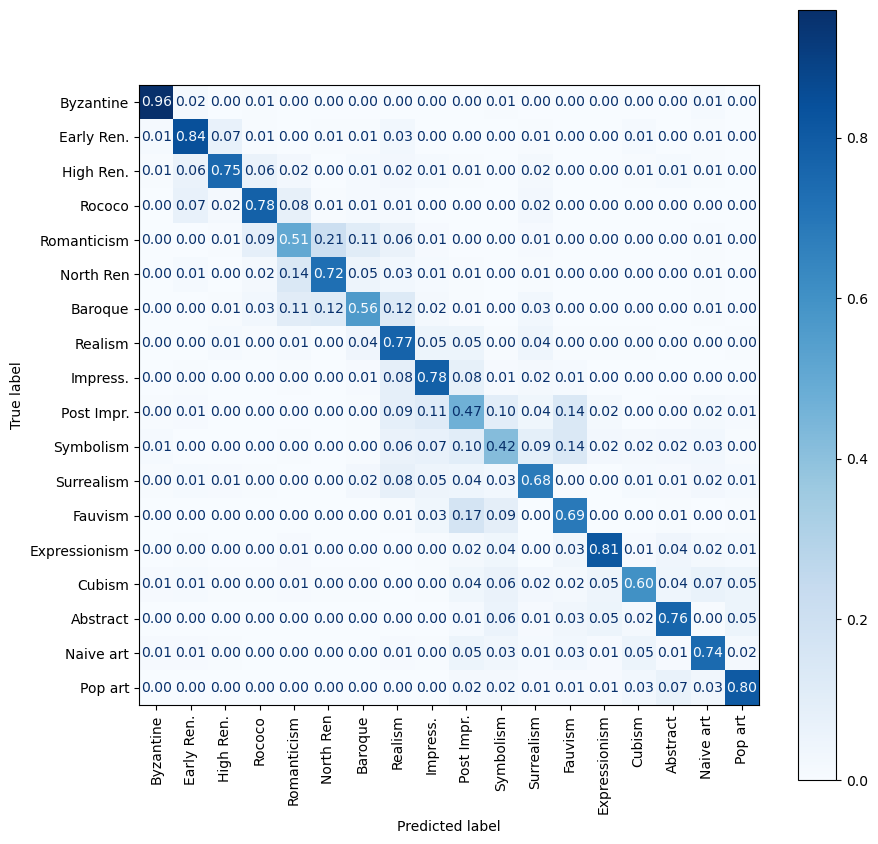

In [41]:
metrics(model, test_dataloader)